# SQL Utils

In [1]:
import sqlite3
import random
from faker import Faker
from datetime import datetime

fake = Faker()

In [2]:
# Connect to (or create) the SQLite database file.
conn = sqlite3.connect("ecommerce.db")
cursor = conn.cursor()

# Create tables
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    username TEXT UNIQUE NOT NULL,
    email TEXT UNIQUE NOT NULL,
    password_hash TEXT NOT NULL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS addresses (
    address_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    street TEXT,
    city TEXT,
    state TEXT,
    zip_code TEXT,
    country TEXT,
    FOREIGN KEY(user_id) REFERENCES users(user_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS categories (
    category_id INTEGER PRIMARY KEY AUTOINCREMENT,
    category_name TEXT UNIQUE NOT NULL,
    description TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    product_name TEXT NOT NULL,
    category_id INTEGER,
    description TEXT,
    price REAL NOT NULL,
    stock_quantity INTEGER DEFAULT 0,
    FOREIGN KEY(category_id) REFERENCES categories(category_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    order_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    total_amount REAL NOT NULL,
    shipping_address_id INTEGER,
    FOREIGN KEY(user_id) REFERENCES users(user_id),
    FOREIGN KEY(shipping_address_id) REFERENCES addresses(address_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_items (
    order_item_id INTEGER PRIMARY KEY AUTOINCREMENT,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER NOT NULL,
    unit_price REAL NOT NULL,
    FOREIGN KEY(order_id) REFERENCES orders(order_id),
    FOREIGN KEY(product_id) REFERENCES products(product_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS payments (
    payment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    order_id INTEGER,
    payment_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    amount REAL NOT NULL,
    payment_method TEXT,
    status TEXT,
    FOREIGN KEY(order_id) REFERENCES orders(order_id)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS reviews (
    review_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    product_id INTEGER,
    rating INTEGER CHECK (rating >= 1 AND rating <= 5),
    comment TEXT,
    review_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY(user_id) REFERENCES users(user_id),
    FOREIGN KEY(product_id) REFERENCES products(product_id)
);
""")

conn.commit()

In [3]:
#####################################
# Populate Users and Addresses
#####################################
num_users = 30
users_data = []
addresses_data = []
for _ in range(num_users):
    username = fake.user_name()
    email = fake.email()
    password_hash = fake.sha256()
    users_data.append((username, email, password_hash))
cursor.executemany("INSERT INTO users (username, email, password_hash) VALUES (?, ?, ?);", users_data)
conn.commit()

# Retrieve user_ids for address generation.
cursor.execute("SELECT user_id FROM users;")
user_ids = [row[0] for row in cursor.fetchall()]

# For simplicity, create one address per user.
for user_id in user_ids:
    street = fake.street_address()
    city = fake.city()
    state = fake.state_abbr()
    zip_code = fake.zipcode()
    country = fake.country()
    addresses_data.append((user_id, street, city, state, zip_code, country))
cursor.executemany(
    "INSERT INTO addresses (user_id, street, city, state, zip_code, country) VALUES (?, ?, ?, ?, ?, ?);",
    addresses_data,
)
conn.commit()

#####################################
# Populate Categories
#####################################
categories_list = [
    "Electronics", "Books", "Clothing", "Home", "Toys",
    "Sports", "Beauty", "Grocery", "Automotive", "Office"
]
categories_data = []
for cat in categories_list:
    description = fake.sentence(nb_words=10)
    categories_data.append((cat, description))
cursor.executemany("INSERT INTO categories (category_name, description) VALUES (?, ?);", categories_data)
conn.commit()

# Get category ids.
cursor.execute("SELECT category_id FROM categories;")
category_ids = [row[0] for row in cursor.fetchall()]

#####################################
# Populate Products
#####################################
num_products = 100
products_data = []
# We'll also store product prices in a list for later reference.
products_list = []
for i in range(num_products):
    product_name = fake.catch_phrase()
    category_id = random.choice(category_ids)
    description = fake.text(max_nb_chars=100)
    price = round(random.uniform(5, 2000), 2)
    stock_quantity = random.randint(0, 500)
    products_data.append((product_name, category_id, description, price, stock_quantity))
cursor.executemany(
    "INSERT INTO products (product_name, category_id, description, price, stock_quantity) VALUES (?, ?, ?, ?, ?);",
    products_data,
)
conn.commit()
# Assuming product_id is sequential (1-indexed).
for i, prod in enumerate(products_data, start=1):
    products_list.append({"product_id": i, "price": prod[3]})

#####################################
# Populate Orders and Order Items
#####################################
num_orders = 200
orders_data = []
order_items_data = []
order_totals = {}  # To store computed total for each order.
# Insert orders with a temporary total_amount of 0.
for _ in range(num_orders):
    user_id = random.choice(user_ids)
    order_date = fake.date_time_between(start_date="-1y", end_date="now")
    # For simplicity, use the user's address (addresses were inserted in order).
    shipping_address_id = user_id  
    orders_data.append((user_id, order_date, 0.0, shipping_address_id))
cursor.executemany(
    "INSERT INTO orders (user_id, order_date, total_amount, shipping_address_id) VALUES (?, ?, ?, ?);",
    orders_data,
)
conn.commit()

# Retrieve orders to generate order items.
cursor.execute("SELECT order_id, user_id, order_date, shipping_address_id FROM orders;")
orders_records = cursor.fetchall()

for order in orders_records:
    order_id, user_id, order_date, shipping_address_id = order
    num_items = random.randint(1, 5)
    total = 0.0
    for _ in range(num_items):
        product = random.choice(products_list)
        product_id = product["product_id"]
        unit_price = product["price"]
        quantity = random.randint(1, 10)
        total += unit_price * quantity
        order_items_data.append((order_id, product_id, quantity, unit_price))
    order_totals[order_id] = round(total, 2)
cursor.executemany(
    "INSERT INTO order_items (order_id, product_id, quantity, unit_price) VALUES (?, ?, ?, ?);",
    order_items_data,
)
conn.commit()

# Update each order with the computed total_amount.
for order_id, total in order_totals.items():
    cursor.execute("UPDATE orders SET total_amount = ? WHERE order_id = ?;", (total, order_id))
conn.commit()

#####################################
# Populate Payments
#####################################
payment_methods = ["Credit Card", "PayPal", "Debit Card"]
payments_data = []
for order in orders_records:
    order_id, user_id, order_date, shipping_address_id = order
    total = order_totals.get(order_id, 0.0)
    payment_date = fake.date_time_between_dates(datetime_start=datetime.strptime(order_date, "%Y-%m-%d %H:%M:%S"), datetime_end=datetime.now())
    payment_method = random.choice(payment_methods)
    status = "Completed"
    payments_data.append((order_id, payment_date, total, payment_method, status))
cursor.executemany(
    "INSERT INTO payments (order_id, payment_date, amount, payment_method, status) VALUES (?, ?, ?, ?, ?);",
    payments_data,
)
conn.commit()

#####################################
# Populate Reviews
#####################################
num_reviews = 300
reviews_data = []
for _ in range(num_reviews):
    user_id = random.choice(user_ids)
    product_id = random.randint(1, num_products)
    rating = random.randint(1, 5)
    comment = fake.sentence(nb_words=12)
    review_date = fake.date_time_between(start_date="-1y", end_date="now")
    reviews_data.append((user_id, product_id, rating, comment, review_date))
cursor.executemany(
    "INSERT INTO reviews (user_id, product_id, rating, comment, review_date) VALUES (?, ?, ?, ?, ?);",
    reviews_data,
)
conn.commit()

print("Database populated successfully with Faker data!")
conn.close()

Database populated successfully with Faker data!


C:\Users\jochua\AppData\Local\Temp\ipykernel_31516\2783885884.py:88: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.executemany(
C:\Users\jochua\AppData\Local\Temp\ipykernel_31516\2783885884.py:133: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.executemany(
C:\Users\jochua\AppData\Local\Temp\ipykernel_31516\2783885884.py:151: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.executemany(


# SQL Agent

In [1]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI

## SQL Tools

In [2]:
from langchain_community.utilities.sql_database import SQLDatabase

In [3]:
# Initalize database 
db = SQLDatabase.from_uri("sqlite:///ecommerce.db")

In [4]:
from langchain_community.tools.sql_database.tool import (
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
    InfoSQLDatabaseTool
)
from langgraph.graph import MessagesState
from langchain_core.messages.system import SystemMessage

In [5]:
sql_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

In [8]:
sql_llm.with_structured_output()

ValueError: schema must be specified when method is not 'json_mode'. Received None.

In [10]:
type(type(sql_llm))

pydantic._internal._model_construction.ModelMetaclass

In [158]:
db_list_tool = ListSQLDatabaseTool(db = db)
# step before executing the sql query to make it more accurate
db_query_checker_tool = QuerySQLCheckerTool(
    db = db,
    llm = sql_llm ) # based on this https://patterns.app/blog/2023-01-18-crunchbot-sql-analyst-gpt
db_query_tool = QuerySQLDatabaseTool(db = db)
db_info_tool = InfoSQLDatabaseTool(db=db)

In [159]:
db_info_tool.description = 'Always use this after listing all the possible tables to get the schema and sample rows for the specified sql tables and when facing erros with column names'

## agent

In [160]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]  # basically passes the history through

graph_builder = StateGraph(MessagesState)


In [161]:
llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

tools = [db_list_tool, db_query_checker_tool, db_query_tool, db_info_tool]
llm = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="""You are a data mapping assistant whose job is to use the database that you are connected to, to match fields with the list of fields in a data set.
There are 2 main objectives:
1. Match fields, and give a confidence rating of low medium high based on how confident you are that that database table field maps to the given field
2. If columns from different data match the same field, convert them same format for example, categories of countries might be (US, EU...) in one but in another it is (America, Europe ...) and numerical value are in the same precision/units.
Lastly You are also profficient with SQL allowing you to generate the SQL scripts to give you the final data table.""")
   
def chatbot(state: MessagesState):
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

In [162]:
import json
from langchain_core.messages import ToolMessage
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [163]:
sql_list_tables_node = BasicToolNode(tools=[db_list_tool])
check_sql_query_node = BasicToolNode(tools=[db_query_checker_tool])
sql_query_table_node = BasicToolNode(tools=[db_query_tool])
sql_tables_info_node = BasicToolNode(tools=[db_info_tool])

In [164]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("sql_list_tables", sql_list_tables_node)
graph_builder.add_node("check_sql_query", check_sql_query_node)
graph_builder.add_node("sql_query_table", sql_query_table_node)
graph_builder.add_node("sql_tables_info", sql_tables_info_node)

In [165]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print("tool call", ai_message.tool_calls)
        # Process the first tool call from the list
        tool_call = ai_message.tool_calls[0]  # Remove the first tool call for processing
        tool_name = tool_call.get("name")
        if not tool_name:
            raise ValueError("Tool call does not specify a tool name.")

        tool_routes = {
            "sql_db_query_checker": "sql_db_query_checker",
            "sql_db_list_tables": "sql_db_list_tables",
            "sql_db_query": "sql_db_query",
            "sql_db_schema": "sql_db_schema"
        }

        if tool_name in tool_routes:
            return tool_routes[tool_name]
        else:
            raise ValueError(f"Unknown tool name: {tool_name}")
    
    # If no more tool calls remain, move to the end node
    return END

In [166]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "sql_db_query_checker": "check_sql_query",
        "sql_db_list_tables": "sql_list_tables",
        "sql_db_query": "sql_query_table",
        "sql_db_schema": "sql_tables_info",
        END: END},
) # allows the LLM to either use the tool or exit

In [167]:
graph_builder.add_edge("check_sql_query", "chatbot")
graph_builder.add_edge("sql_query_table", "chatbot")
graph_builder.add_edge("sql_list_tables", "chatbot")
graph_builder.add_edge("sql_tables_info", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

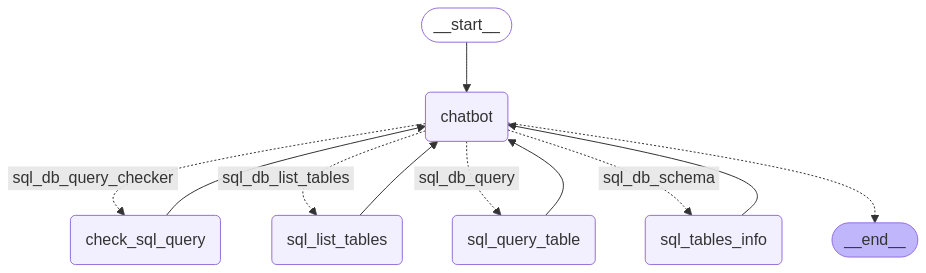

In [168]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [169]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            pass

In [130]:
while True:

    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)


Goodbye!


In [113]:
stream_graph_updates('what are the columns in the different tables')

tool call [{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_x0EyPfk3asJSlNf9zybPXn7P', 'type': 'tool_call'}]
Assistant: 
Assistant: "addresses, categories, order_items, orders, payments, products, reviews, users"
tool call [{'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(addresses);'}, 'id': 'call_SK36RcVCX83b3yZKLB9uq76a', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(categories);'}, 'id': 'call_iz1X3C4OCeu9x6vn6VQh0JgL', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(order_items);'}, 'id': 'call_Hbr6bxCI8h1wld7Bjxy9Xn9D', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(orders);'}, 'id': 'call_GUVBxIPPjcSBM2GSyVe23bnL', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(payments);'}, 'id': 'call_jACdweDwuDNOoBj7uayxmZGv', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': 'PRAGMA table_info(products);'}, 'id':

In [142]:
stream_graph_updates('what is the monthly decrease in revenue for items in the electronics category, also find out some possible reasons for it based on the reviews data from the database')

tool call [{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_JneeBZf7Bja4P1hVRGXT7FRp', 'type': 'tool_call'}]
Assistant: 
Assistant: "addresses, categories, order_items, orders, payments, products, reviews, users"
tool call [{'name': 'sql_db_query', 'args': {'query': "SELECT SUM(order_items.price * order_items.quantity) AS total_revenue, DATE_TRUNC('month', orders.order_date) AS month\nFROM order_items\nJOIN orders ON order_items.order_id = orders.id\nJOIN products ON order_items.product_id = products.id\nJOIN categories ON products.category_id = categories.id\nWHERE categories.name = 'Electronics'\nGROUP BY month\nORDER BY month;"}, 'id': 'call_uQpVn3WTwK6sQ0NUko60OhwD', 'type': 'tool_call'}, {'name': 'sql_db_query', 'args': {'query': "SELECT review_text, rating\nFROM reviews\nJOIN products ON reviews.product_id = products.id\nJOIN categories ON products.category_id = categories.id\nWHERE categories.name = 'Electronics';"}, 'id': 'call_JiNjo1ePVALuJH6Kfcyyroap', 'type': 'tool_cal

In [144]:
stream_graph_updates('what is the monthly decrease in revenue for items in the electronics category')

tool call [{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_w3aVA0IhieiUTyLPSJnvt7my', 'type': 'tool_call'}]
Assistant: 
Assistant: "addresses, categories, order_items, orders, payments, products, reviews, users"
tool call [{'name': 'sql_db_schema', 'args': {'table_names': 'categories, products, order_items, orders, payments'}, 'id': 'call_qzLYZPC68mqo870AeNt50Fdn', 'type': 'tool_call'}, {'name': 'sql_db_query_checker', 'args': {'query': "SELECT SUM(p.price * oi.quantity) AS total_revenue, DATE_TRUNC('month', o.order_date) AS month\nFROM order_items oi\nJOIN products p ON oi.product_id = p.id\nJOIN categories c ON p.category_id = c.id\nJOIN orders o ON oi.order_id = o.id\nWHERE c.name = 'Electronics'\nGROUP BY month\nORDER BY month;"}, 'id': 'call_StAlKb0QauAh643jMrlie8GG', 'type': 'tool_call'}, {'name': 'sql_db_query_checker', 'args': {'query': "SELECT SUM(p.price * oi.quantity) AS total_revenue, DATE_TRUNC('month', o.order_date) AS month\nFROM order_items oi\nJOIN products p ON

KeyError: 'sql_db_query_checker'

In [170]:
stream_graph_updates('table field: user id, email, most bought product, most common payment method')

tool call [{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_byJHRMS12x1zUiZJDp39OVcY', 'type': 'tool_call'}]
Assistant: 
Assistant: "addresses, categories, order_items, orders, payments, products, reviews, users"
tool call [{'name': 'sql_db_schema', 'args': {'table_names': 'users'}, 'id': 'call_43NjFlgcEX4zHi57aXt5LHSd', 'type': 'tool_call'}, {'name': 'sql_db_schema', 'args': {'table_names': 'orders'}, 'id': 'call_gXM46pM4stJgU7mOSiFtufTY', 'type': 'tool_call'}, {'name': 'sql_db_schema', 'args': {'table_names': 'payments'}, 'id': 'call_9LZqrvh224oL1wI7lKyF28Yh', 'type': 'tool_call'}, {'name': 'sql_db_schema', 'args': {'table_names': 'products'}, 'id': 'call_1NKxAkxPK0YbbE0wwQDJP8FM', 'type': 'tool_call'}]
Assistant: 
Assistant: "\nCREATE TABLE products (\n\tproduct_id INTEGER, \n\tproduct_name TEXT NOT NULL, \n\tcategory_id INTEGER, \n\tdescription TEXT, \n\tprice REAL NOT NULL, \n\tstock_quantity INTEGER DEFAULT 0, \n\tPRIMARY KEY (product_id), \n\tFOREIGN KEY(category_id) REFER